In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Add, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models

In [3]:
import os
from tqdm import tqdm

# Path to your image folder (update this with your folder path)
BASE_DIRS = [r"D:\Data science\datasets\Age\UTKFace"]  # <-- change path

image_paths = []
age_labels = []
gender_paths = []

for BASE_DIR in BASE_DIRS:  # ✅ corrected variable name
    for filename in tqdm(os.listdir(BASE_DIR)):
        temp = filename.split('_')  # UTKFace format: age_gender_race_date.jpg
        if temp[0].isdigit():
            age = int(temp[0])
            gender = int(temp[1])

            image_path = os.path.join(BASE_DIR, filename)
            image_paths.append(image_path)
            age_labels.append(age)
            gender_paths.append(gender)



100%|████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 244991.35it/s]


In [4]:
df=pd.DataFrame()
df['image'],df['age'],df['gender'] = image_paths,age_labels,gender_paths
df.head()

,image,age,gender
0,D:\Data science\datasets\Age\UTKFace\100_0_0_2...,100,0
1,D:\Data science\datasets\Age\UTKFace\100_0_0_2...,100,0
2,D:\Data science\datasets\Age\UTKFace\100_1_0_2...,100,1
3,D:\Data science\datasets\Age\UTKFace\100_1_0_2...,100,1
4,D:\Data science\datasets\Age\UTKFace\100_1_0_2...,100,1


In [5]:
df.tail()

,image,age,gender
23703,D:\Data science\datasets\Age\UTKFace\9_1_3_201...,9,1
23704,D:\Data science\datasets\Age\UTKFace\9_1_3_201...,9,1
23705,D:\Data science\datasets\Age\UTKFace\9_1_4_201...,9,1
23706,D:\Data science\datasets\Age\UTKFace\9_1_4_201...,9,1
23707,D:\Data science\datasets\Age\UTKFace\9_1_4_201...,9,1


In [6]:
print(f"DataFrame : {df}")

DataFrame :                                                    image  age  gender
0      D:\Data science\datasets\Age\UTKFace\100_0_0_2...  100       0
1      D:\Data science\datasets\Age\UTKFace\100_0_0_2...  100       0
2      D:\Data science\datasets\Age\UTKFace\100_1_0_2...  100       1
3      D:\Data science\datasets\Age\UTKFace\100_1_0_2...  100       1
4      D:\Data science\datasets\Age\UTKFace\100_1_0_2...  100       1
...                                                  ...  ...     ...
23703  D:\Data science\datasets\Age\UTKFace\9_1_3_201...    9       1
23704  D:\Data science\datasets\Age\UTKFace\9_1_3_201...    9       1
23705  D:\Data science\datasets\Age\UTKFace\9_1_4_201...    9       1
23706  D:\Data science\datasets\Age\UTKFace\9_1_4_201...    9       1
23707  D:\Data science\datasets\Age\UTKFace\9_1_4_201...    9       1

[23708 rows x 3 columns]


In [7]:
gender_dict = {0:"male",1:"Female"}

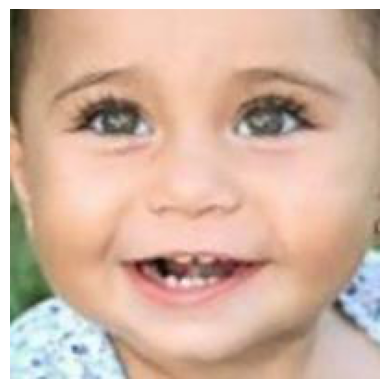

In [8]:
if not df.empty:
    try:
        img=Image.open(df['image'][10500])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print("Eroor")
else:
    print("Data empty")

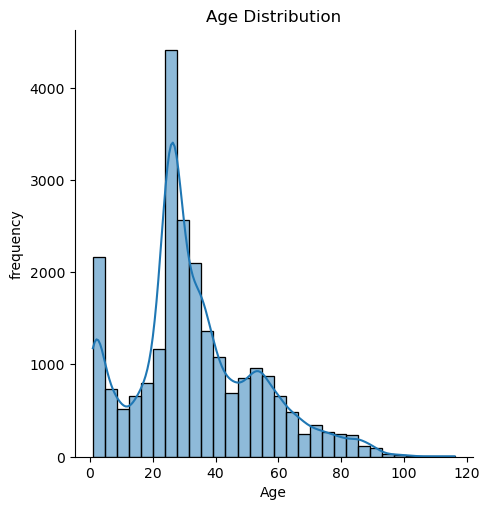

In [9]:
sns.displot(df['age'],kde=True,bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("frequency")
plt.show()

In [10]:
def feature_extract(images):
    features=[]
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img=img.resize((128,128), Image.BILINEAR)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),128,128,1)
    return features

In [11]:
x = feature_extract(df['image'])
print("X: \t{x.shape}" )

100%|███████████████████████████████████████████████████████████████████████████| 23708/23708 [00:33<00:00, 712.95it/s]


X: 	{x.shape}


In [12]:
x=x/255.0
y_gender= np.array(df['gender'])
y_age= np.array(df['age'])
print(y_age.shape)


(23708,)


In [13]:
input_shape = (128,128,1)
inputs = Input(input_shape)
conv1 = Conv2D(32, kernel_size=(3,3),activation='relu')(inputs)
maxp1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(64, kernel_size=(3,3),activation='relu')(maxp1)
maxp2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(128, kernel_size=(3,3),activation='relu')(maxp2)
maxp3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(256, kernel_size=(3,3),activation='relu')(maxp3)
maxp4 = MaxPooling2D(pool_size=(2,2))(conv4)
flatten = Flatten()(maxp4)
dense1 = Dense(256,activation='relu')(flatten)
dense2 = Dense(256,activation='relu')(flatten)
droupout1 = Dropout(0.3)(dense1)
droupout2 = Dropout(0.3)(dense2)
output1 = Dense(1, activation='sigmoid', name= 'gender_out')(droupout1)
output2 = Dense(1, activation='relu', name= 'age_out')(droupout2)
model = Model(inputs=inputs,outputs=[output1,output2])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 126, 126, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 63, 63, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 61, 61, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 30, 30, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 14, 14, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 12, 12, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 6, 6, 256)         │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 9216)              │               0 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       2,359,552 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │       2,359,552 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_out (Dense)            │ (None, 1)                 │             257 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_out (Dense)               │ (None, 1)                 │             25

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
y_combined = np.column_stack((y_gender,y_age))
X_train,X_temp,y_combined_train,y_combined_temp = train_test_split(x,y_combined,test_size = 0.2 , random_state = 42)

In [15]:
x_test,x_val,y_combined_test,y_combined_val = train_test_split(X_temp , y_combined_temp,test_size=0.5, random_state = 42)

In [16]:
y_train_gender , y_train_age = y_combined_train[:,0] , y_combined_train[:,1]
y_test_gender , y_test_age = y_combined_test[:,0] , y_combined_test[:,1]
y_val_gender , y_val_age = y_combined_val[:,0] , y_combined_val[:,1]

In [17]:
model_path = './best_model.keras'
checkpointer = ModelCheckpoint(filepath = model_path, monitor = 'val_gender_out_accuracy',verbose = 1, mode='max' , save_best_only=True)

In [18]:
from keras.callbacks import LearningRateScheduler
model.compile(loss=['binary_crossentropy','mae'], optimizer = 'adam' , metrics = ['accuracy','mae'])
annealer = LearningRateScheduler(lambda x:1e-3*0.9**x)

In [19]:
total_images = len(image_paths)
print("Total images ",total_images)

Total images  23708


In [20]:
train_images = len(X_train)
validation_images = len(x_val)
test_images = len(x_test)
print("Trained images ", train_images)
print("Validation images ", validation_images)
print("test images ", test_images)



Trained images  18966
Validation images  2371
test images  2371


In [21]:
tf.config.run_functions_eagerly(True)

In [46]:
history = model.fit(x=X_train, y=[y_train_gender , y_train_age] , batch_size = 128 , epochs = 100 , 
                    validation_data = (x_val,[y_val_gender,y_val_age]),callbacks=[annealer , checkpointer])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - age_out_loss: 19.1619 - age_out_mae: 19.1619 - gender_out_accuracy: 0.5150 - gender_out_loss: 0.6951 - loss: 19.8571
Epoch 1: val_gender_out_accuracy improved from -inf to 0.52256, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 113s 752ms/step - age_out_loss: 19.1431 - age_out_mae: 19.1431 - gender_out_accuracy: 0.5149 - gender_out_loss: 0.6951 - loss: 19.8382 - val_age_out_loss: 15.3112 - val_age_out_mae: 15.3112 - val_gender_out_accuracy: 0.5226 - val_gender_out_loss: 0.6926 - val_loss: 16.0037 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - age_out_loss: 15.0867 - age_out_mae: 15.0867 - gender_out_accuracy: 0.5227 - gender_out_loss: 0.6926 - loss: 15.7792
Epoch 2: val_gender_out_accuracy did not improve from 0.52256
149/149 ━━━━━━━━━━━━━━━━━━━━ 110s 740ms/step - age_out_loss: 15.0880 - age_out_mae: 15.0880 - gender_out_accuracy: 0.5227 - gender_out_loss: 0.6926 - loss: 15.7805 

In [47]:
model.save('age_cnn_model.h5')  # HDF5 format


In [1]:
from tensorflow.keras.models import load_model

model = load_model("age_cnn_model.h5", compile=False)


In [2]:
import cv2
import numpy as np
from PIL import Image

def preprocess_image(image_path):
    # load image
    img = Image.open(image_path).convert('L')   # grayscale
    img = img.resize((128,128), Image.BILINEAR) # resize
    img = np.array(img)
    img = img.reshape(1,128,128,1)              # add batch dimension
    img = img / 255.0                           # normalize
    return img


In [3]:
def predict_age_gender(image_path):
    img = preprocess_image(image_path)
    
    gender_pred, age_pred = model.predict(img)
    
    gender = "Male" if gender_pred[0][0] < 0.5 else "Female"
    age = int(age_pred[0][0])   # round off
    
    print(f"Predicted Gender: {gender}")
    print(f"Predicted Age: {age} years")
    return gender, age


In [4]:
image_path = "babyface1.jpg"  # change to your image
predict_age_gender(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Predicted Gender: Male
Predicted Age: 33 years


('Male', 33)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Gender: Male
Predicted Age: 32 years


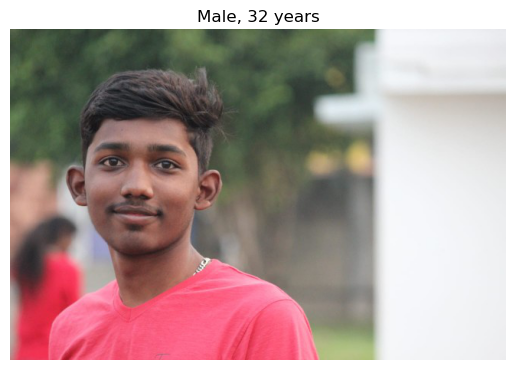

In [8]:
import matplotlib.pyplot as plt

def show_prediction(image_path):
    gender, age = predict_age_gender(image_path)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{gender}, {age} years")
    plt.show()

show_prediction(image_path)



25-10-22 21:13:09 - Directory C:\Users\harsh\.deepface has been created
25-10-22 21:13:09 - Directory C:\Users\harsh\.deepface\weights has been created


In [25]:
from deepface import DeepFace

# Predict attributes
analysis = DeepFace.analyze(img_path="harshaold.jpg", actions=['age', 'gender'])



Action: gender: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.62it/s]


In [26]:
age = analysis[0]['age']
predicted_gender = analysis[0]['dominant_gender']


In [27]:
age

22

In [28]:
predicted_gender

'Man'

In [6]:
pip install keras-vggface

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install keras-applications

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade deepface


Note: you may need to restart the kernel to use updated packages.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import save_model

# Load pretrained model
age_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)
gender_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

# Save as .h5
save_model(age_model, "age_model.h5")
save_model(gender_model, "gender_model.h5")


In [16]:
pip install keras-vggface keras-applications


Note: you may need to restart the kernel to use updated packages.


In [20]:
from deepface import DeepFace

# Analyze the image for age and gender
result = DeepFace.analyze("harsha.jpg", actions=['age', 'gender'])

# Extract and print the results
age = result[0]['age']
gender = result[0]['dominant_gender']
print(f"Predicted Age: {age}")
print(f"Predicted Gender: {gender}")


Action: gender: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]

Predicted Age: 23
Predicted Gender: Man
